# Controlling a 2D drone
This notebook extends the approach in the `closedloopcontrol` notebook and builds a simple simulator + hierarchical controller for a 2D drone.

First, the usual preparations. See previous notebooks.

In [1]:
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
import ipywidgets


def mktr(x, y):
    return np.array([[1, 0, x],
                     [0, 1, y],
                     [0, 0, 1]])


def mkrot(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta), np.cos(theta), 0],
                     [0, 0, 1]])


def drawf(f, ax=None, name=None):
    """ Draw frame defined by f on axis ax (if provided) or on plt.gca() otherwise """
    xhat = f @ np.array([[0, 0, 1], [1, 0, 1]]).T
    yhat = f @ np.array([[0, 0, 1], [0, 1, 1]]).T
    if(not ax):
        ax = plt.gca()
    ax.plot(xhat[0, :], xhat[1, :], 'r-')  # transformed x unit vector
    ax.plot(yhat[0, :], yhat[1, :], 'g-')  # transformed y unit vector
    if(name):
        ax.text(xhat[0, 0], xhat[1, 0], name, va="top", ha="center")


class PID:

    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.last_e = None
        self.sum_e = 0

    def step(self, e, dt):
        """ dt should be the time interval from the last method call """
        if(self.last_e is not None):
            derivative = (e - self.last_e) / dt
        else:
            derivative = 0
        self.last_e = e
        self.sum_e += e * dt
        return self.Kp * e + self.Kd * derivative + self.Ki * self.sum_e

## Simulation and drawing
We start by building the code to simulate the drone.  Our drone is controlled through two thrusters, one on the left and one on the right, at a distance of `L`.  State is defined by pose (`pose`), 2D translation velocity (`v`)  and rotational velocity (`omega`).  In the `step` function, given a left and right thrust, we compute:
- the total force acting on the drone (gravity + left thruster + right thruster).  Note that gravity always points down, but thruster force points to the direction corresponding to the drone orientation.  This affects the drone's linear acceleration.
- the torque acting on the drone w.r.t. its center of mass.  This affects the drone's angular acceleration.

In [2]:
class Drone2D:
    def __init__(self, initial_pose, mass, L):
        self.pose = initial_pose
        self.mass = mass
        self.moment_of_inertia = mass * L**2
        self.L = L
        self.v = np.array([0.0, 0.0])  # in the world reference frame
        self.omega = 0.0

    def getxy(self):
        return self.pose[0:2, 2]  # extracts [x,y] from current pose

    def gettheta(self):  # sin(theta)      cos(theta)
        return np.arctan2(self.pose[1, 0], self.pose[0, 0])

    def step(self, thrustl_f, thrustr_f, dt):
        gravity_force = np.array([0, -9.8 * self.mass])
        theta = self.gettheta()
        thrust_force = (np.array([np.cos(theta+np.pi/2), np.sin(theta+np.pi/2)])
                        * (thrustr_f + thrustl_f))
        force = gravity_force + thrust_force
        torque = self.L * (thrustr_f - thrustl_f)
        acceleration = force / self.mass
        self.v = self.v + acceleration * dt
        angular_acceleration = torque / self.moment_of_inertia
        self.omega = self.omega + angular_acceleration * dt
        self.pose = mktr(*(self.v * dt)) @ self.pose @ mkrot(self.omega * dt)

Here is a function to draw a drone, given its pose and the thruster distance `L`.  If current thrust values are given in the `thrusts` optional parameter (as `[left_thrust, right_thrust]`), we'll draw two nice triangles to represent these values.

In [3]:
def drawDrone2D(pose, L, thrusts=[0, 0], ax=None, alpha=0.5):
    """ draw robot at current pose,
    on axis ax (if provided) or on plt.gca() otherwise. """

    if(not ax):
        ax = plt.gca()

    # This is the chassis of the robot, a long arrow
    robot = ([[-1, 1, 0, -1],  # x
              [0, 0, 0.3,  0]])  # y
    robot = np.array(robot)
    robot = np.vstack((
        robot * L,  # scale by L units
        np.ones((1, robot.shape[1]))))
    # ... and now it's in homogeneous coordinates

    thrust = np.array(([[-0.1,  0, 0.1, -0.1],   # x
                        [0, -1, 0,  0]]))  # y
    thrustl = mktr(-L, 0) @ np.vstack((
        thrust * thrusts[0] * 0.1,
        np.ones((1, thrust.shape[1]))))
    thrustr = mktr(+L, 0) @ np.vstack((
        thrust * thrusts[1] * 0.1,
        np.ones((1, thrust.shape[1]))))

    robott = pose @ robot
    thrustlt = pose @ thrustl
    thrustrt = pose @ thrustr
    hrobot = ax.plot(robott[0, :], robott[1, :], 'k-',
                     alpha=alpha)   # Draw the chassis
    hthrustl = ax.plot(thrustlt[0, :], thrustlt[1, :],
                       'y-', alpha=alpha)   # Draw the chassis
    hthrustr = ax.plot(thrustrt[0, :], thrustrt[1, :],
                       'y-', alpha=alpha)   # Draw the chassis
    return hrobot[0], hthrustl[0], hthrustr[0]

Here is our drone at the origin, with both thrusters generating 10 N of force.

(-1.2100000000000002,
 1.2100000000000002,
 -1.0649999999999999,
 0.36499999999999999)

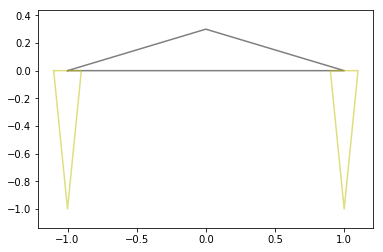

In [4]:
drawDrone2D(np.eye(3), 1, thrusts=[10, 10])
plt.axis("equal")

## Height and attitude control

We now implement two parallel controllers; one controls the height of the drone, the other controls the orientation.  The former controls both thrusters at the same time, the other affects the difference between the left and right thrusters.  Note that we make sure that each thruster can't generate a negative force, nor a force larger than a maximum value.

In [6]:
%matplotlib inline
# height control + attitude control

L = 1
d = Drone2D(mkrot(-0.5), L, 1)
maxthrust = 20
desired_height = 5
desired_theta = 0
height_controller = PID(10, 0, 5)
theta_controller = PID(10, 0, 5)
dt = 0.1
ts = np.arange(0, 5, dt)
poses = []
for t in ts:
    x, y = d.getxy()
    theta = d.gettheta()

    theta_error = desired_theta - theta
    theta_diff_thrust = theta_controller.step(theta_error, dt)

    height_error = desired_height - y
    height_thrust = height_controller.step(height_error, dt)

    thrust = height_thrust + np.array([-1, +1]) * theta_diff_thrust
    thrust = np.clip(thrust, 0, maxthrust)
    d.step(thrust[0], thrust[1], dt)
    poses.append(d.pose)

fig, ax = plt.subplots(); plt.close() # we need this plot for animation only
ax.axis("equal")
hrobots = []


def animate(i):
    for hrobot in hrobots:
        [hr.set_visible(False) for hr in hrobot]
    hrobots.append(drawDrone2D(poses[i], L, ax=ax))


import matplotlib.animation
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(poses))

from IPython.display import HTML
display(HTML(ani.to_jshtml()))

Note that the drone drifts on one side, and that's fine: both controllers are perfectly fine once the drone keeps a given height and stays horizontal.  If we had implemented drag in our simulation, the drone would eventually stop.

## Position control
We now build a more complex control scheme to reach a specific 2D point.  The architecture is similar to the above architecture, with a small difference.  Now, the `desired_theta` that the `theta_controller` wants to reach is not always 0, but is decided by another higher-level controller, which we call `x_controller`. `x_controller` operates on `desired_theta` in order to minimize the error `desired_x - x`.

In [ ]:
# position control

d = Drone2D(mkrot(-0.9), 1, 1)
maxthrust = 20
desired_height = 5
desired_x = -5
height_controller = PID(10, 0, 15)
x_controller = PID(-0.05, 0, -0.1)
theta_controller = PID(10, 0, 5)
theta_limit = 0.6
dt = 0.05
ts = np.arange(0, 10, dt)
poses = []
thrusts = []
for t in ts:
    x, y = d.getxy()
    theta = d.gettheta()

    x_error = desired_x - x
    desired_theta = x_controller.step(x_error, dt)
    desired_theta = np.clip(desired_theta, -theta_limit, +theta_limit)

    theta_error = desired_theta - theta
    theta_diff_thrust = theta_controller.step(theta_error, dt)
    theta_diff_thrust = np.clip(
        theta_diff_thrust, -0.5 * maxthrust, +0.5 * maxthrust)

    height_error = desired_height - y
    height_thrust = height_controller.step(height_error, dt)

    thrust = height_thrust + np.array([-1, +1]) * theta_diff_thrust
    
    # The two lines below are not strictly needed, but improve the
    # performance in some difficult cases.  In order to undersand
    # what they do, consider what happens when height_thrust is
    # very large (or very negative). In that case, theta_diff_thrust
    # would have no effect at all, because its effect would be
    # clamped by the following np.clip operation.  Then, both
    # thrusters would have the same power (0 or maxthrust) and the
    # drone would be unable to change its rotational speed.
    # The two lines below prevent this problem.
    #
    # thrust = thrust - min(0, np.min(thrust))
    # thrust = thrust - max(0, np.max(thrust) - maxthrust)
    
    thrust = np.clip(thrust, 0, maxthrust)
    d.step(thrust[0], thrust[1], dt)
    poses.append(d.pose)
    thrusts.append(thrust)

fig, ax = plt.subplots(figsize=(10, 10)); plt.close()
ax.axis("equal")
ax.axhline(y=0)
ax.plot(desired_x, desired_height, "b*")


def animate(i):
    for hrobot in hrobots:
        [hr.set_visible(False) for hr in hrobot]
    hrobots.append(drawDrone2D(poses[i], L, thrusts[i], ax=ax))


import matplotlib.animation
ani = matplotlib.animation.FuncAnimation(
    fig, animate, frames=len(poses), interval=int(dt*1000))

from IPython.display import HTML
HTML(ani.to_jshtml())

# Exercises
* By trial and error, derive the PID gains starting from scratch
* Test your controller on many scenarios, changing the initial poses, target position, drone mass.  When you find a scenario where the controller breaks, find a way to fix it.
* Once you have a challenging scenario, uncomment the two lines  
  ``` thrust = thrust - min(0, np.min(thrust)) ```  
  ``` thrust = thrust - max(0, np.max(thrust) - maxthrust)```  
  and check whether it improves performance.
* Test your controller with the drone starting almost upside down
* Test your controller with the drone starting in a very fast spin (5 turns per second).  Note, this requires a significant overhaul of the whole approach.